In [1]:
import pandas as pd, numpy as np, time
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    f1_score, roc_auc_score
)
import matplotlib.pyplot as plt


In [2]:
PATH = Path("data/processed/places_cleaned.parquet")

assert PATH.exists(), f"Missing cleaned file: {PATH}"

df = pd.read_parquet(PATH)
print("Loaded:", df.shape)
print(df.head(3))

expected_cols = [
    "label","name","base_name",
    "address","base_address",
    "website","base_website",
    "phone","base_phone"
]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print("\nMissing rates (%):")
print((df[expected_cols].isna().mean()*100).round(2))

print("\nEmpty-string rates (%):")
print(((df[expected_cols].astype(str)=="").mean()*100).round(2))

print("\nLabel balance:")
print(df["label"].value_counts(normalize=True).round(3))

Loaded: (2731, 13)
   label                                id                           base_id  \
0    1.0  08f391ab10c7114d033517ea0e3905a9                   562949956772225   
1    0.0  08f26ed44c0f20f103c3e3cc6e5bed37                  1407374886409435   
2    0.0  08f2a100d649b2940358781f0b0c6078  08f2a10725b1451a03d80f18dbf3f667   

                              name                                 address  \
0                               bp  avenida carlos cano | los barrios | es   
1         northwest medical center  609 w maple ave | springdale | ar | us   
2  manhattan hardware & housewares        688 9th ave | new york | ny | us   

                                             website         phone  \
0  https://map.bp.com/es-es/es/estacion-de-servic...  +34956621050   
1                    http://www.northwesthealth.com/  +14797515711   
2              https://twitter.com/#!/9thavehardware  +12127574555   

                                   base_name  \
0                 

In [4]:
X_left  = df["name"].astype(str).tolist()
X_right = df["base_name"].astype(str).tolist()
y = df["label"].astype(int).values

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

def encode_with_latency(texts):
    t0 = time.perf_counter()
    E = model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
    ms = (time.perf_counter() - t0)*1000/len(texts)
    return E, ms

E1, ms1 = encode_with_latency(X_left)
E2, ms2 = encode_with_latency(X_right)
latency_ms = (ms1 + ms2)/2
print(f"\nEncode latency ≈ {latency_ms:.1f} ms/query")

sims = (E1 * E2).sum(axis=1)  # cosine since normalized

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rows = []
for tr, te in skf.split(sims, y):
    ths = np.linspace(0.3, 0.9, 61)
    best_t, best_f1 = 0.5, -1
    for t in ths:
        f1 = f1_score(y[tr], (sims[tr] >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    yhat = (sims[te] >= best_t).astype(int)
    acc = accuracy_score(y[te], yhat)
    p, r, f1, _ = precision_recall_fscore_support(y[te], yhat, average="binary", zero_division=0)
    s = sims[te]; s = (s - s.min())/(s.max()-s.min()+1e-9)
    auc = roc_auc_score(y[te], s)
    rows.append((best_t, acc, p, r, f1, auc))

res_minilm = pd.DataFrame(rows, columns=["best_t","acc","prec","rec","f1","auc"])
print("\nMiniLM 3-fold results:")
print(res_minilm.round(3))
print("Averages:", res_minilm.mean().round(3).to_dict())

res_minilm.assign(model="MiniLM-L6-v2", enc_ms_per_query=latency_ms)\
          .to_csv("reports/minilm_results.csv", index=False)
print("Saved → reports/minilm_results.csv")



Encode latency ≈ 0.9 ms/query

MiniLM 3-fold results:
   best_t    acc   prec    rec     f1    auc
0    0.72  0.727  0.742  0.838  0.787  0.799
1    0.72  0.712  0.720  0.852  0.781  0.805
2    0.72  0.752  0.753  0.874  0.809  0.823
Averages: {'best_t': 0.72, 'acc': 0.73, 'prec': 0.738, 'rec': 0.854, 'f1': 0.792, 'auc': 0.809}
Saved → minilm_results.csv


In [5]:
def combine_fields(name, addr="", phone=""):
    parts = [str(name)]
    if isinstance(addr, str) and addr.strip():
        parts.append(str(addr))
    if isinstance(phone, str) and phone.strip():
        parts.append(str(phone))
    return " [SEP] ".join(parts)

df["text_name_only_left"]  = df["name"].astype(str)
df["text_name_only_right"] = df["base_name"].astype(str)

df["text_name_addr_left"]  = df.apply(
    lambda x: combine_fields(x["name"], x["address"]), axis=1
)
df["text_name_addr_right"] = df.apply(
    lambda x: combine_fields(x["base_name"], x["base_address"]), axis=1
)

df["text_full_left"]  = df.apply(
    lambda x: combine_fields(x["name"], x["address"], x["phone"]), axis=1
)
df["text_full_right"] = df.apply(
    lambda x: combine_fields(x["base_name"], x["base_address"], x["base_phone"]), axis=1
)

y = df["label"].astype(int).values

print(df[[
    "text_name_only_left","text_name_addr_left","text_full_left"
]].head(3))


               text_name_only_left  \
0                               bp   
1         northwest medical center   
2  manhattan hardware & housewares   

                                 text_name_addr_left  \
0    bp [SEP] avenida carlos cano | los barrios | es   
1  northwest medical center [SEP] 609 w maple ave...   
2  manhattan hardware & housewares [SEP] 688 9th ...   

                                      text_full_left  
0  bp [SEP] avenida carlos cano | los barrios | e...  
1  northwest medical center [SEP] 609 w maple ave...  
2  manhattan hardware & housewares [SEP] 688 9th ...  


In [6]:
try:
    model_e5 = SentenceTransformer("intfloat/e5-small-v2")
    def enc_e5(texts):
        t0 = time.perf_counter()
        E = model_e5.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
        ms = (time.perf_counter() - t0)*1000/len(texts)
        return E, ms

    E1e5, ms1e5 = enc_e5(X_left)
    E2e5, ms2e5 = enc_e5(X_right)
    latency_ms_e5 = (ms1e5 + ms2e5)/2
    sims_e5 = (E1e5 * E2e5).sum(axis=1)

    rows = []
    for tr, te in skf.split(sims_e5, y):
        ths = np.linspace(0.3, 0.9, 61)
        best_t, best_f1 = 0.5, -1
        for t in ths:
            f1 = f1_score(y[tr], (sims_e5[tr] >= t).astype(int))
            if f1 > best_f1:
                best_f1, best_t = f1, t
        yhat = (sims_e5[te] >= best_t).astype(int)
        acc = accuracy_score(y[te], yhat)
        p, r, f1, _ = precision_recall_fscore_support(y[te], yhat, average="binary", zero_division=0)
        s = sims_e5[te]; s = (s - s.min())/(s.max()-s.min()+1e-9)
        auc = roc_auc_score(y[te], s)
        rows.append((best_t, acc, p, r, f1, auc))

    res_e5 = pd.DataFrame(rows, columns=["best_t","acc","prec","rec","f1","auc"])
    print("\nE5-small-v2 3-fold results:")
    print(res_e5.round(3))
    print("Averages:", res_e5.mean().round(3).to_dict())

    res_e5.assign(model="E5-small-v2", enc_ms_per_query=latency_ms_e5)\
           .to_csv("reports/e5_results.csv", index=False)
    print("Saved → reports/e5_results.csv")
except Exception as e:
    print("E5 baseline skipped:", e)



E5-small-v2 3-fold results:
   best_t    acc   prec    rec     f1    auc
0     0.9  0.706  0.701  0.892  0.785  0.806
1     0.9  0.700  0.692  0.901  0.783  0.812
2     0.9  0.735  0.722  0.910  0.805  0.829
Averages: {'best_t': 0.9, 'acc': 0.714, 'prec': 0.705, 'rec': 0.901, 'f1': 0.791, 'auc': 0.816}
Saved → e5_results.csv



Summary:
           model       acc        f1  enc_ms_per_query
0   E5-small-v2  0.713661  0.791082          1.159605
1  MiniLM-L6-v2  0.730137  0.792000          0.941732


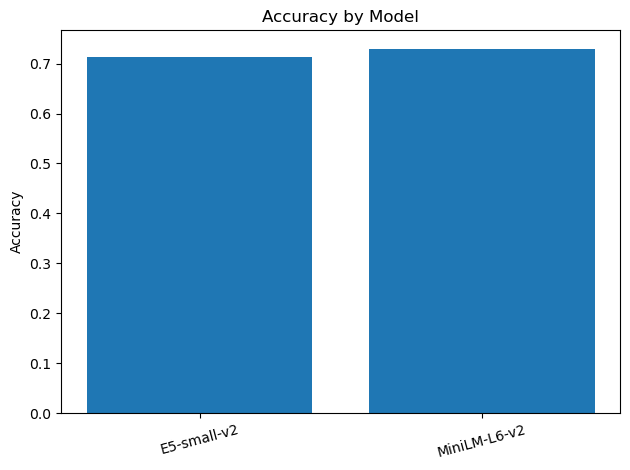

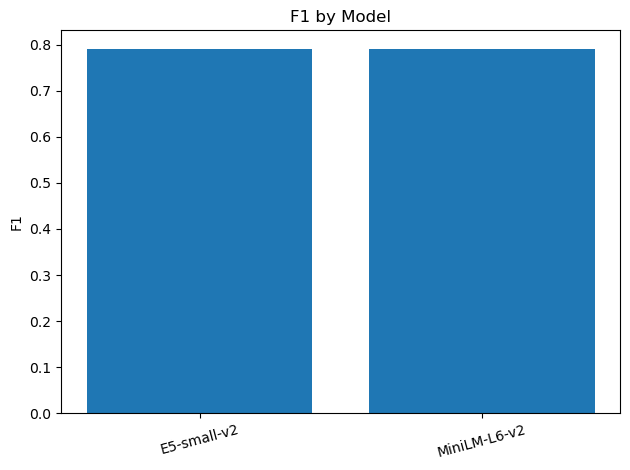

In [7]:
import matplotlib.pyplot as plt, os
dfs=[]
for f in ["reports/minilm_results.csv","reports/e5_results.csv"]:
    if os.path.exists(f):
        dfs.append(pd.read_csv(f))
if dfs:
    R = pd.concat(dfs, ignore_index=True)
    summary = R.groupby("model", as_index=False)[["acc","f1","enc_ms_per_query"]].mean()
    print("\nSummary:\n", summary)
    plt.figure()
    plt.bar(summary["model"], summary["acc"])
    plt.title("Accuracy by Model")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig("accuracy_by_model.png", dpi=150)
    plt.show()

    plt.figure()
    plt.bar(summary["model"], summary["f1"])
    plt.title("F1 by Model")
    plt.ylabel("F1")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig("f1_by_model.png", dpi=150)
    plt.show()
else:
    print("No results to plot yet.")

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

import time

def encode_with_latency(model, texts):
    t0 = time.perf_counter()
    E = model.encode(
        texts,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    ms = (time.perf_counter() - t0) * 1000 / len(texts)
    return E, ms

def run_model_cv(model_name, left_text, right_text, y, n_splits=3,
                 t_min=0.5, t_max=0.99, t_steps=50):
    print(f"\n=== {model_name} on {left_text.name} ===")
    from sentence_transformers import SentenceTransformer

    model = SentenceTransformer(model_name)

    X_left  = left_text.astype(str).tolist()
    X_right = right_text.astype(str).tolist()

    E1, ms1 = encode_with_latency(model, X_left)
    E2, ms2 = encode_with_latency(model, X_right)
    enc_ms = (ms1 + ms2) / 2
    print(f"Encode latency ≈ {enc_ms:.2f} ms/query")

    sims = (E1 * E2).sum(axis=1)   # cosine because normalized
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    rows = []
    ths = np.linspace(t_min, t_max, t_steps)

    for fold, (tr, te) in enumerate(skf.split(sims, y), 1):
        best_t, best_f1 = 0.5, -1
        for t in ths:
            yhat_tr = (sims[tr] >= t).astype(int)
            f1_tr = f1_score(y[tr], yhat_tr)
            if f1_tr > best_f1:
                best_f1, best_t = f1_tr, t

        yhat = (sims[te] >= best_t).astype(int)

        acc = accuracy_score(y[te], yhat)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y[te], yhat, average="binary", zero_division=0
        )
        # per-class + weighted F1 (for OKR 2)
        _, _, f1_per_class, _ = precision_recall_fscore_support(
            y[te], yhat, average=None, zero_division=0
        )
        f1_nonmatch, f1_match = f1_per_class[0], f1_per_class[1]
        _, _, f1_weighted, _ = precision_recall_fscore_support(
            y[te], yhat, average="weighted", zero_division=0
        )
        s = sims[te]
        auc = roc_auc_score(y[te], s)

        rows.append({
            "fold": fold,
            "best_t": best_t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "f1_match": f1_match,
            "f1_nonmatch": f1_nonmatch,
            "f1_weighted": f1_weighted,
            "auc": auc,
        })

    res = pd.DataFrame(rows)
    summary = res.mean().round(3).to_dict()
    summary["enc_ms_per_query"] = round(enc_ms, 3)
    print("Fold results:\n", res.round(3))
    print("Averages:", summary)
    return res, summary, sims


In [9]:
summaries = []

# 1) BGE-small, name + address (good starting point)
res_bge_small_na, sum_bge_small_na, sims_bge_small_na = run_model_cv(
    "BAAI/bge-small-en-v1.5",
    df["text_name_addr_left"],
    df["text_name_addr_right"],
    y
)
sum_bge_small_na["model"] = "bge-small-en-v1.5"
sum_bge_small_na["view"]  = "name+address"
summaries.append(sum_bge_small_na)

# 2)BGE-base
res_bge_base_na, sum_bge_base_na, sims_bge_base_na = run_model_cv(
    "BAAI/bge-base-en-v1.5",
    df["text_name_addr_left"],
    df["text_name_addr_right"],
    y
)
sum_bge_base_na["model"] = "bge-base-en-v1.5"
sum_bge_base_na["view"]  = "name+address"
summaries.append(sum_bge_base_na)

# 3)BGE-small name-only
res_bge_small_n, sum_bge_small_n, sims_bge_small_n = run_model_cv(
    "BAAI/bge-small-en-v1.5",
    df["text_name_only_left"],
    df["text_name_only_right"],
    y
)
sum_bge_small_n["model"] = "bge-small-en-v1.5"
sum_bge_small_n["view"]  = "name-only"
summaries.append(sum_bge_small_n)

summary_df = pd.DataFrame(summaries)
print("\nSummary across models/views:\n", summary_df)
summary_df.to_csv("reports/bge_summaries.csv", index=False)



=== BAAI/bge-small-en-v1.5 on text_name_addr_left ===
Encode latency ≈ 2.14 ms/query
Fold results:
    fold  best_t    acc   prec    rec     f1  f1_match  f1_nonmatch  \
0     1    0.87  0.776  0.765  0.907  0.830     0.830        0.673   
1     2    0.88  0.768  0.773  0.870  0.819     0.819        0.679   
2     3    0.89  0.803  0.826  0.852  0.839     0.839        0.748   

   f1_weighted    auc  
0        0.767  0.872  
1        0.763  0.862  
2        0.802  0.885  
Averages: {'fold': 2.0, 'best_t': 0.88, 'acc': 0.782, 'prec': 0.788, 'rec': 0.876, 'f1': 0.829, 'f1_match': 0.829, 'f1_nonmatch': 0.7, 'f1_weighted': 0.778, 'auc': 0.873, 'enc_ms_per_query': 2.143}

=== BAAI/bge-base-en-v1.5 on text_name_addr_left ===
Encode latency ≈ 6.76 ms/query
Fold results:
    fold  best_t    acc   prec    rec     f1  f1_match  f1_nonmatch  \
0     1    0.87  0.797  0.803  0.878  0.839     0.839        0.726   
1     2    0.87  0.773  0.777  0.872  0.822     0.822        0.686   
2     3    0.8

In [10]:
def separation_stats(sims, y, label):
    pos = sims[y == 1]
    neg = sims[y == 0]
    sep = pos.mean() - neg.mean()
    print(f"{label}: mean(pos)={pos.mean():.3f}, mean(neg)={neg.mean():.3f}, Δ={sep:.3f}")
    return sep

# baseline (use your stored MiniLM sims if you kept them;
# if not, rerun quickly with your old code and reuse those sims)
# Example assuming you re-compute MiniLM with name-only:
# sep_minilm = separation_stats(sims_minilm, y, "MiniLM name-only")

sep_bge_small_na = separation_stats(sims_bge_small_na, y, "BGE-small name+addr")
sep_bge_small_n  = separation_stats(sims_bge_small_n,  y, "BGE-small name-only")


BGE-small name+addr: mean(pos)=0.951, mean(neg)=0.845, Δ=0.106
BGE-small name-only: mean(pos)=0.940, mean(neg)=0.822, Δ=0.119


In [11]:
def threshold_stats(res, label):
    mean_t = res["best_t"].mean()
    var_t  = res["best_t"].var()
    print(f"{label}: mean_t={mean_t:.3f}, var={var_t:.5f}")
    return mean_t, var_t

threshold_stats(res_bge_small_na, "BGE-small name+addr")
threshold_stats(res_bge_small_n,  "BGE-small name-only")


BGE-small name+addr: mean_t=0.880, var=0.00010
BGE-small name-only: mean_t=0.837, var=0.00003


(0.8366666666666668, 3.333333333333339e-05)

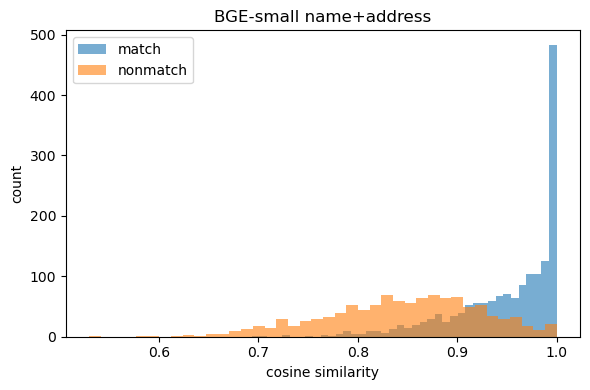

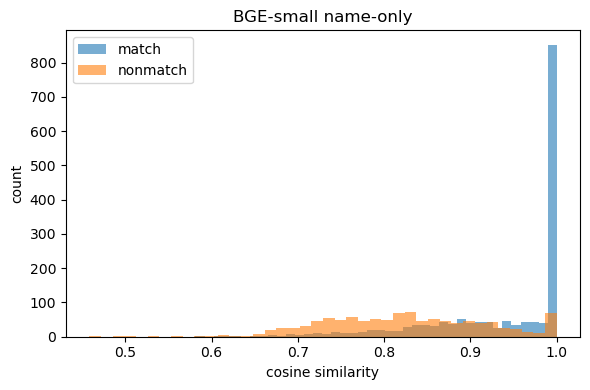

In [12]:
import matplotlib.pyplot as plt

def plot_sep(sims, y, title):
    plt.figure(figsize=(6,4))
    plt.hist(sims[y==1], bins=40, alpha=0.6, label="match")
    plt.hist(sims[y==0], bins=40, alpha=0.6, label="nonmatch")
    plt.legend()
    plt.title(title)
    plt.xlabel("cosine similarity")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

plot_sep(sims_bge_small_na, y, "BGE-small name+address")
plot_sep(sims_bge_small_n,  y, "BGE-small name-only")


In [14]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# 1) Load cleaned data
df = pd.read_parquet("data/processed/places_cleaned.parquet")
print(df.shape)
print(df.columns)

# Make sure label is binary int
df["label_bin"] = df["label"].astype(int)

# 2) Build text fields for left/right sides
def safe_str(s):
    if pd.isna(s):
        return ""
    return str(s)

# Name-only text
df["text_name_left"]  = df["name"].apply(safe_str).str.lower()
df["text_name_right"] = df["base_name"].apply(safe_str).str.lower()

# Name + address text
df["text_name_addr_left"] = (
    df["name"].apply(safe_str) + ". " + df["address"].apply(safe_str)
).str.lower()

df["text_name_addr_right"] = (
    df["base_name"].apply(safe_str) + ". " + df["base_address"].apply(safe_str)
).str.lower()

# 3) Load embedding model
MODEL_NAME = "BAAI/bge-base-en-v1.5"   # or "BAAI/bge-small-en-v1.5"
model = SentenceTransformer(MODEL_NAME)

def embed_batch(texts, batch_size=64):
    texts = texts.fillna("").astype(str).tolist()
    all_emb = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, show_progress_bar=False, normalize_embeddings=True)
        all_emb.append(emb)
    return np.vstack(all_emb)

print("Embedding name-only texts...")
emb_name_left  = embed_batch(df["text_name_left"])
emb_name_right = embed_batch(df["text_name_right"])

df["sim_name"] = (emb_name_left * emb_name_right).sum(axis=1)

print("Embedding name+address texts...")
emb_na_left  = embed_batch(df["text_name_addr_left"])
emb_na_right = embed_batch(df["text_name_addr_right"])

df["sim_nameaddr"] = (emb_na_left * emb_na_right).sum(axis=1)

# 4) Simple phone match feature
def clean_phone(x):
    if pd.isna(x):
        return ""
    return "".join(ch for ch in str(x) if ch.isdigit())

left_phone  = df["phone"].apply(clean_phone)
right_phone = df["base_phone"].apply(clean_phone)

df["same_phone"] = (
    (left_phone != "") &
    (right_phone != "") &
    (left_phone == right_phone)
).astype(int)

df[["sim_name", "sim_nameaddr", "same_phone", "label_bin"]].head()


(2731, 13)
Index(['label', 'id', 'base_id', 'name', 'address', 'website', 'phone',
       'base_name', 'base_address', 'base_website', 'base_phone', 'confidence',
       'base_confidence'],
      dtype='object')
Embedding name-only texts...
Embedding name+address texts...


,sim_name,sim_nameaddr,same_phone,label_bin
0,1.000000,0.842120,0,1
1,0.831252,0.924668,0,0
2,0.592672,0.580979,0,0
3,0.762588,0.804951,0,0
4,0.851364,0.876494,0,1


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import StratifiedKFold

feature_cols = ["sim_name", "sim_nameaddr", "same_phone"]

X = df[feature_cols].values
y = df["label_bin"].values

print("Feature matrix shape:", X.shape)

clf = LogisticRegression(
    class_weight="balanced",
    max_iter=200,
    n_jobs=-1,
    solver="lbfgs"
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)  # can tune later
    
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    f1_weighted = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]
    
    try:
        auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        auc = np.nan
    
    print(f"\nFold {fold}")
    print(f"  acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}  f1_weighted={f1_weighted:.3f}  auc={auc:.3f}")
    
    fold_results.append({
        "fold": fold,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "f1_weighted": f1_weighted,
        "auc": auc
    })

res_df = pd.DataFrame(fold_results)
print("\nAverages:")
print(res_df.mean(numeric_only=True).round(3))


Feature matrix shape: (2731, 3)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just


Fold 1
  acc=0.799  prec=0.859  rec=0.797  f1=0.827  f1_weighted=0.801  auc=0.883

Fold 2
  acc=0.786  prec=0.826  rec=0.815  f1=0.821  f1_weighted=0.786  auc=0.866

Fold 3
  acc=0.815  prec=0.864  rec=0.823  f1=0.843  f1_weighted=0.816  auc=0.887

Averages:
fold           2.000
acc            0.800
prec           0.849
rec            0.812
f1             0.830
f1_weighted    0.801
auc            0.879
dtype: float64


In [16]:
df["text_full_left"] = (
    df["name"].astype(str) + ". " +
    df["address"].astype(str) + ". " +
    df["phone"].astype(str)
).str.lower()

df["text_full_right"] = (
    df["base_name"].astype(str) + ". " +
    df["base_address"].astype(str) + ". " +
    df["base_phone"].astype(str)
).str.lower()
print("Embedding full-text inputs...")
emb_full_left  = embed_batch(df["text_full_left"])
emb_full_right = embed_batch(df["text_full_right"])

df["sim_full"] = (emb_full_left * emb_full_right).sum(axis=1)



Embedding full-text inputs...


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

feature_cols = ["sim_name", "sim_nameaddr", "sim_full", "same_phone"]
X = df[feature_cols].values
y = df["label_bin"].values

clf = LogisticRegression(class_weight="balanced", max_iter=300)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    clf.fit(X[tr], y[tr])
    proba = clf.predict_proba(X[te])[:,1]
    
    best_f1 = 0
    best_t = 0.5
    
    for t in np.linspace(0.4, 0.8, 41):
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y[te], y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    
    y_pred = (proba >= best_t).astype(int)
    acc = accuracy_score(y[te], y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y[te], y_pred, average="binary")

    print(f"\nFold {fold}: best_t={best_t:.2f}  F1={f1:.3f}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}")
    results.append(f1)

print("\n=== FINAL AVERAGE F1 ===")
print(np.mean(results))



Fold 1: best_t=0.40  F1=0.842  Acc=0.804  Prec=0.814  Rec=0.872

Fold 2: best_t=0.40  F1=0.827  Acc=0.780  Prec=0.784  Rec=0.876

Fold 3: best_t=0.41  F1=0.847  Acc=0.811  Prec=0.824  Rec=0.872

=== FINAL AVERAGE F1 ===
0.8389420229584137


In [18]:
MODEL_NAME = "thenlper/gte-large"
model = SentenceTransformer(MODEL_NAME)

emb_name_left  = embed_batch(df["text_name_left"])
emb_name_right = embed_batch(df["text_name_right"])

emb_na_left  = embed_batch(df["text_name_addr_left"])
emb_na_right = embed_batch(df["text_name_addr_right"])

emb_full_left  = embed_batch(df["text_full_left"])
emb_full_right = embed_batch(df["text_full_right"])
df["sim_name"] = (emb_name_left * emb_name_right).sum(axis=1)
df["sim_nameaddr"] = (emb_na_left * emb_na_right).sum(axis=1)
df["sim_full"] = (emb_full_left * emb_full_right).sum(axis=1)


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support

feature_cols = ["sim_name", "sim_nameaddr", "sim_full", "same_phone"]
X = df[feature_cols].values
y = df["label_bin"].values

clf = LogisticRegression(class_weight="balanced", max_iter=300)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    clf.fit(X[tr], y[tr])
    proba = clf.predict_proba(X[te])[:,1]
    
    best_f1 = 0
    best_t = 0.5
    
    for t in np.linspace(0.4, 0.8, 41):
        y_pred = (proba >= t).astype(int)
        f1 = f1_score(y[te], y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    
    y_pred = (proba >= best_t).astype(int)
    acc = accuracy_score(y[te], y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y[te], y_pred, average="binary")

    print(f"\nFold {fold}: best_t={best_t:.2f}  F1={f1:.3f}  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}")
    results.append(f1)

print("\n=== FINAL AVERAGE F1 ===")
print(np.mean(results))



Fold 1: best_t=0.43  F1=0.849  Acc=0.811  Prec=0.819  Rec=0.881

Fold 2: best_t=0.41  F1=0.831  Acc=0.781  Prec=0.777  Rec=0.892

Fold 3: best_t=0.40  F1=0.851  Acc=0.809  Prec=0.800  Rec=0.909

=== FINAL AVERAGE F1 ===
0.8435077800412758


In [25]:
# import numpy as np
# import pandas as pd

# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import (
#     accuracy_score,
#     precision_recall_fscore_support,
#     roc_auc_score
# )

# # 1) Load data with features (or reuse df in memory)
# df = pd.read_parquet("places_cleaned.parquet")  # or "places_cleaned.parquet" if you kept everything there

# # Make sure label is int
# df["label_bin"] = df["label"].astype(int)

# # Choose feature set
# feature_cols = [
#     "sim_name",
#     "sim_nameaddr",
#     # "sim_full",              # uncomment if you have it
#     "same_phone",
#     "same_website_domain",
#     "confidence",
#     "base_confidence",
# ]

# X = df[feature_cols].values
# y = df["label_bin"].values

# print("Feature matrix:", X.shape)

# # 2) Model
# clf = GradientBoostingClassifier(
#     n_estimators=200,
#     learning_rate=0.05,
#     max_depth=3,
#     subsample=0.9,
#     random_state=42
# )

# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# fold_rows = []
# all_f1 = []

# for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), start=1):
#     X_tr, X_te = X[tr_idx], X[te_idx]
#     y_tr, y_te = y[tr_idx], y[te_idx]

#     clf.fit(X_tr, y_tr)

#     # use probabilities so we *could* tune threshold later
#     y_proba = clf.predict_proba(X_te)[:, 1]

#     # simple 0.5 threshold first
#     y_hat = (y_proba >= 0.5).astype(int)

#     acc = accuracy_score(y_te, y_hat)
#     prec, rec, f1, _ = precision_recall_fscore_support(
#         y_te, y_hat, average="binary", zero_division=0
#     )
#     f1_weighted = precision_recall_fscore_support(
#         y_te, y_hat, average="weighted", zero_division=0
#     )[2]

#     try:
#         auc = roc_auc_score(y_te, y_proba)
#     except ValueError:
#         auc = np.nan

#     print(f"\nFold {fold}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, "
#           f"f1={f1:.3f}, f1_weighted={f1_weighted:.3f}, auc={auc:.3f}")

#     fold_rows.append(
#         dict(
#             fold=fold,
#             acc=acc,
#             prec=prec,
#             rec=rec,
#             f1=f1,
#             f1_weighted=f1_weighted,
#             auc=auc
#         )
#     )
#     all_f1.append(f1)

# res = pd.DataFrame(fold_rows)
# print("\nAverages:")
# print(res.mean(numeric_only=True).round(3))
# print("\nMean F1:", np.mean(all_f1))


import numpy as np
import pandas as pd
from urllib.parse import urlparse

from sentence_transformers import SentenceTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

# 1) Load cleaned data
df = pd.read_parquet("data/processed/places_cleaned.parquet")
print("Loaded:", df.shape)
print("Original columns:", df.columns.tolist())

# Make sure label is binary int
df["label_bin"] = df["label"].astype(int)

def safe_str(x):
    return "" if pd.isna(x) else str(x)

# --- Build text views ---

# Name-only
df["text_name_left"]  = df["name"].apply(safe_str).str.lower()
df["text_name_right"] = df["base_name"].apply(safe_str).str.lower()

# Name + address
df["text_name_addr_left"] = (
    df["name"].apply(safe_str) + ". " + df["address"].apply(safe_str)
).str.lower()

df["text_name_addr_right"] = (
    df["base_name"].apply(safe_str) + ". " + df["base_address"].apply(safe_str)
).str.lower()

# --- Embeddings with a SMALL, FAST model ---
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # or "BAAI/bge-small-en-v1.5"
model = SentenceTransformer(MODEL_NAME)
print("Using model:", MODEL_NAME)

def embed_batch(texts, batch_size=64):
    texts = texts.fillna("").astype(str).tolist()
    all_emb = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(
            batch,
            normalize_embeddings=True,
            show_progress_bar=False,
        )
        all_emb.append(emb)
    return np.vstack(all_emb)

print("Embedding name-only...")
emb_l = embed_batch(df["text_name_left"])
emb_r = embed_batch(df["text_name_right"])
df["sim_name"] = (emb_l * emb_r).sum(axis=1)

print("Embedding name+address...")
emb_l = embed_batch(df["text_name_addr_left"])
emb_r = embed_batch(df["text_name_addr_right"])
df["sim_nameaddr"] = (emb_l * emb_r).sum(axis=1)

# --- Phone feature ---
def clean_phone(x):
    return "".join(ch for ch in str(x) if ch.isdigit()) if pd.notna(x) else ""

left_phone  = df["phone"].apply(clean_phone)
right_phone = df["base_phone"].apply(clean_phone)

df["same_phone"] = (
    (left_phone != "") &
    (right_phone != "") &
    (left_phone == right_phone)
).astype(int)

# --- Website domain feature ---
def get_domain(url):
    if pd.isna(url) or not str(url).strip():
        return ""
    try:
        parsed = urlparse(str(url))
        host = parsed.netloc.lower()
        if host.startswith("www."):
            host = host[4:]
        return host
    except Exception:
        return ""

left_dom  = df["website"].apply(get_domain)
right_dom = df["base_website"].apply(get_domain)

df["same_website_domain"] = (
    (left_dom != "") &
    (right_dom != "") &
    (left_dom == right_dom)
).astype(int)

print("\nAfter feature engineering, columns are:")
print(df.columns.tolist())

print("\nFeature preview:")
print(df[["sim_name", "sim_nameaddr", "same_phone", "same_website_domain", "label_bin"]].head())

# 2) Build feature matrix for classifier

feature_cols = [
    "sim_name",
    "sim_nameaddr",
    "same_phone",
    "same_website_domain",
    "confidence",
    "base_confidence",
]

# sanity check: see which ones are missing (should be empty list)
missing = [c for c in feature_cols if c not in df.columns]
print("\nMissing from df:", missing)

X = df[feature_cols].values
y = df["label_bin"].values

print("\nFeature matrix shape:", X.shape)

# 3) Gradient Boosting + 3-fold CV with threshold sweep

clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    random_state=42,
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

fold_rows = []
best_fs = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # threshold sweep
    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0.3, 0.7, 41):
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t

    # compute final metrics at best_t
    y_pred = (y_proba >= best_t).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1_bin, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    f1_weighted = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]

    try:
        auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        auc = np.nan

    print(
        f"\nFold {fold}: best_t={best_t:.2f} "
        f"Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} "
        f"F1={f1_bin:.3f} F1_weighted={f1_weighted:.3f} AUC={auc:.3f}"
    )

    fold_rows.append(
        dict(
            fold=fold,
            best_t=best_t,
            acc=acc,
            prec=prec,
            rec=rec,
            f1=f1_bin,
            f1_weighted=f1_weighted,
            auc=auc,
        )
    )
    best_fs.append(f1_bin)

res = pd.DataFrame(fold_rows)
print("\n=== Averages across folds ===")
print(res.mean(numeric_only=True).round(3))

print("\n=== FINAL AVERAGE F1 ===")
print(np.mean(best_fs))


Loaded: (2731, 13)
Original columns: ['label', 'id', 'base_id', 'name', 'address', 'website', 'phone', 'base_name', 'base_address', 'base_website', 'base_phone', 'confidence', 'base_confidence']
Using model: sentence-transformers/all-MiniLM-L6-v2
Embedding name-only...
Embedding name+address...

After feature engineering, columns are:
['label', 'id', 'base_id', 'name', 'address', 'website', 'phone', 'base_name', 'base_address', 'base_website', 'base_phone', 'confidence', 'base_confidence', 'label_bin', 'text_name_left', 'text_name_right', 'text_name_addr_left', 'text_name_addr_right', 'sim_name', 'sim_nameaddr', 'same_phone', 'same_website_domain']

Feature preview:
   sim_name  sim_nameaddr  same_phone  same_website_domain  label_bin
0  1.000000      0.837201           0                    0          1
1  0.844664      0.905451           0                    1          0
2  0.311306      0.380687           0                    0          0
3  0.671053      0.782712           0        

In [23]:
import numpy as np
import pandas as pd
from urllib.parse import urlparse

from sentence_transformers import SentenceTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score
)

# 1) Load cleaned data
df = pd.read_parquet("data/processed/places_cleaned.parquet")
print("Loaded:", df.shape)
print(df.columns)

# Make sure label is binary int
df["label_bin"] = df["label"].astype(int)

def safe_str(x):
    return "" if pd.isna(x) else str(x)

# --- Build text views ---

# Name-only
df["text_name_left"]  = df["name"].apply(safe_str).str.lower()
df["text_name_right"] = df["base_name"].apply(safe_str).str.lower()

# Name + address
df["text_name_addr_left"] = (
    df["name"].apply(safe_str) + ". " + df["address"].apply(safe_str)
).str.lower()

df["text_name_addr_right"] = (
    df["base_name"].apply(safe_str) + ". " + df["base_address"].apply(safe_str)
).str.lower()

# --- Embeddings with a SMALL, FAST model ---

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"  # or "BAAI/bge-small-en-v1.5"
model = SentenceTransformer(MODEL_NAME)
print("Using model:", MODEL_NAME)

def embed_batch(texts, batch_size=64):
    texts = texts.fillna("").astype(str).tolist()
    all_emb = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(
            batch,
            normalize_embeddings=True,
            show_progress_bar=False
        )
        all_emb.append(emb)
    return np.vstack(all_emb)

print("Embedding name-only...")
emb_l = embed_batch(df["text_name_left"])
emb_r = embed_batch(df["text_name_right"])
df["sim_name"] = (emb_l * emb_r).sum(axis=1)

print("Embedding name+address...")
emb_l = embed_batch(df["text_name_addr_left"])
emb_r = embed_batch(df["text_name_addr_right"])
df["sim_nameaddr"] = (emb_l * emb_r).sum(axis=1)

# --- Phone feature ---

def clean_phone(x):
    return "".join(ch for ch in str(x) if ch.isdigit()) if pd.notna(x) else ""

left_phone  = df["phone"].apply(clean_phone)
right_phone = df["base_phone"].apply(clean_phone)

df["same_phone"] = (
    (left_phone != "") &
    (right_phone != "") &
    (left_phone == right_phone)
).astype(int)

# --- Website domain feature ---

def get_domain(url):
    if pd.isna(url) or not str(url).strip():
        return ""
    try:
        parsed = urlparse(str(url))
        host = parsed.netloc.lower()
        if host.startswith("www."):
            host = host[4:]
        return host
    except Exception:
        return ""

left_dom  = df["website"].apply(get_domain)
right_dom = df["base_website"].apply(get_domain)

df["same_website_domain"] = (
    (left_dom != "") &
    (right_dom != "") &
    (left_dom == right_dom)
).astype(int)

print("\nFeature preview:")
print(df[["sim_name", "sim_nameaddr", "same_phone", "same_website_domain", "label_bin"]].head())

# 2) Build feature matrix for classifier

feature_cols = [
    "sim_name",
    "sim_nameaddr",
    "same_phone",
    "same_website_domain",
    "confidence",
    "base_confidence",
]

X = df[feature_cols].values
y = df["label_bin"].values

print("\nFeature matrix shape:", X.shape)

# 3) Gradient Boosting + 3-fold CV with threshold sweep

clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    random_state=42
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

fold_rows = []
best_fs = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # threshold sweep
    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0.3, 0.7, 41):
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t

    # compute final metrics at best_t
    y_pred = (y_proba >= best_t).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1_bin, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    f1_weighted = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )[2]

    try:
        auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        auc = np.nan

    print(
        f"\nFold {fold}: best_t={best_t:.2f} "
        f"Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} "
        f"F1={f1_bin:.3f} F1_weighted={f1_weighted:.3f} AUC={auc:.3f}"
    )

    fold_rows.append(
        dict(
            fold=fold,
            best_t=best_t,
            acc=acc,
            prec=prec,
            rec=rec,
            f1=f1_bin,
            f1_weighted=f1_weighted,
            auc=auc,
        )
    )
    best_fs.append(f1_bin)

res = pd.DataFrame(fold_rows)
print("\n=== Averages across folds ===")
print(res.mean(numeric_only=True).round(3))

print("\n=== FINAL AVERAGE F1 ===")
print(np.mean(best_fs))


Loaded: (2731, 13)
Index(['label', 'id', 'base_id', 'name', 'address', 'website', 'phone',
       'base_name', 'base_address', 'base_website', 'base_phone', 'confidence',
       'base_confidence'],
      dtype='object')
Using model: sentence-transformers/all-MiniLM-L6-v2
Embedding name-only...
Embedding name+address...

Feature preview:
   sim_name  sim_nameaddr  same_phone  same_website_domain  label_bin
0  1.000000      0.837201           0                    0          1
1  0.844664      0.905451           0                    1          0
2  0.311306      0.380687           0                    0          0
3  0.671053      0.782712           0                    1          0
4  0.773339      0.688265           0                    0          1

Feature matrix shape: (2731, 6)

Fold 1: best_t=0.40 Acc=0.798 Prec=0.803 Rec=0.880 F1=0.840 F1_weighted=0.795 AUC=0.888

Fold 2: best_t=0.39 Acc=0.797 Prec=0.787 Rec=0.907 F1=0.843 F1_weighted=0.791 AUC=0.882

Fold 3: best_t=0.53 Acc=0.812

In [29]:
# Run this in a Colab cell:
!pip install fuzzywuzzy python-Levenshtein


python(7138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.7 MB/s eta 0:00:00


In [30]:
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz  # pip install fuzzywuzzy python-Levenshtein

def string_features(name_a, name_b, addr_a, addr_b):
    """Add traditional string similarity features"""
    
    # Exact match flags
    exact_name = int(name_a.lower().strip() == name_b.lower().strip())
    
    # Fuzzy string similarity (0-100)
    name_ratio = fuzz.ratio(name_a.lower(), name_b.lower()) / 100.0
    name_partial = fuzz.partial_ratio(name_a.lower(), name_b.lower()) / 100.0
    name_token_sort = fuzz.token_sort_ratio(name_a.lower(), name_b.lower()) / 100.0
    
    addr_ratio = fuzz.ratio(addr_a.lower(), addr_b.lower()) / 100.0
    
    # Levenshtein distance (normalized)
    name_lev = SequenceMatcher(None, name_a.lower(), name_b.lower()).ratio()
    
    return {
        'exact_name': exact_name,
        'name_ratio': name_ratio,
        'name_partial': name_partial,
        'name_token_sort': name_token_sort,
        'addr_ratio': addr_ratio,
        'name_levenshtein': name_lev
    }

# Add to your feature engineering:
string_feats = df.apply(
    lambda row: string_features(row['name'], row['base_name'], 
                                row['address'], row['base_address']),
    axis=1
)
string_df = pd.DataFrame(string_feats.tolist())
df = pd.concat([df, string_df], axis=1)

# New feature list:
feature_cols = [
    "sim_name", "sim_nameaddr", 
    "same_phone", "same_website_domain",
    "exact_name", "name_ratio", "name_partial", 
    "name_token_sort", "addr_ratio", "name_levenshtein"
]

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, precision_recall_fscore_support, roc_auc_score
)
from urllib.parse import urlparse
from difflib import SequenceMatcher
from fuzzywuzzy import fuzz
import time

print("="*80)
print("ENHANCED PLACES CONFLATION PIPELINE")
print("="*80)

# ==================== LOAD DATA ====================
print("\n[1/8] Loading data...")
df = pd.read_parquet("data/processed/places_cleaned.parquet")
print(f"Loaded: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

df["label_bin"] = df["label"].astype(int)

# ==================== HELPER FUNCTIONS ====================

def safe_str(x):
    """Convert to string, handling NaN"""
    return "" if pd.isna(x) else str(x)

def clean_phone(x):
    """Extract digits only from phone number"""
    s = safe_str(x)
    return "".join(ch for ch in s if ch.isdigit())

def get_domain(url):
    """Extract domain from URL"""
    s = safe_str(url).strip()
    if not s:
        return ""
    try:
        parsed = urlparse(s)
        host = parsed.netloc.lower()
        if host.startswith("www."):
            host = host[4:]
        return host
    except:
        return ""

def embed_batch(texts, model, batch_size=64):
    """Batch encode texts with progress"""
    texts = texts.fillna("").astype(str).tolist()
    all_emb = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, normalize_embeddings=True, show_progress_bar=False)
        all_emb.append(emb)
    return np.vstack(all_emb)

# ==================== TEXT PREPARATION ====================
print("\n[2/8] Preparing text fields...")

df["text_name_left"] = df["name"].apply(safe_str).str.lower()
df["text_name_right"] = df["base_name"].apply(safe_str).str.lower()

df["text_name_addr_left"] = (
    df["name"].apply(safe_str) + ". " + df["address"].apply(safe_str)
).str.lower()
df["text_name_addr_right"] = (
    df["base_name"].apply(safe_str) + ". " + df["base_address"].apply(safe_str)
).str.lower()

print("✓ Text fields ready")

# ==================== EMBEDDING FEATURES ====================
print("\n[3/8] Computing embedding features...")

# Load multiple embedding models for ensemble
print("  Loading MiniLM...")
minilm = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

print("  Loading BGE-base...")
bge_base = SentenceTransformer("BAAI/bge-base-en-v1.5")

print("  Loading E5-small...")
e5_small = SentenceTransformer("intfloat/e5-small-v2")

# Embed with MiniLM
print("  Embedding with MiniLM (name only)...")
start = time.time()
emb_minilm_name_left = embed_batch(df["text_name_left"], minilm)
emb_minilm_name_right = embed_batch(df["text_name_right"], minilm)
df["sim_minilm_name"] = (emb_minilm_name_left * emb_minilm_name_right).sum(axis=1)
print(f"    Done in {time.time()-start:.2f}s")

print("  Embedding with MiniLM (name+address)...")
start = time.time()
emb_minilm_na_left = embed_batch(df["text_name_addr_left"], minilm)
emb_minilm_na_right = embed_batch(df["text_name_addr_right"], minilm)
df["sim_minilm_nameaddr"] = (emb_minilm_na_left * emb_minilm_na_right).sum(axis=1)
print(f"    Done in {time.time()-start:.2f}s")

# Embed with BGE-base
print("  Embedding with BGE-base (name only)...")
start = time.time()
emb_bge_name_left = embed_batch(df["text_name_left"], bge_base)
emb_bge_name_right = embed_batch(df["text_name_right"], bge_base)
df["sim_bge_name"] = (emb_bge_name_left * emb_bge_name_right).sum(axis=1)
print(f"    Done in {time.time()-start:.2f}s")

print("  Embedding with BGE-base (name+address)...")
start = time.time()
emb_bge_na_left = embed_batch(df["text_name_addr_left"], bge_base)
emb_bge_na_right = embed_batch(df["text_name_addr_right"], bge_base)
df["sim_bge_nameaddr"] = (emb_bge_na_left * emb_bge_na_right).sum(axis=1)
print(f"    Done in {time.time()-start:.2f}s")

# Embed with E5-small
print("  Embedding with E5-small (name only)...")
start = time.time()
emb_e5_name_left = embed_batch(df["text_name_left"], e5_small)
emb_e5_name_right = embed_batch(df["text_name_right"], e5_small)
df["sim_e5_name"] = (emb_e5_name_left * emb_e5_name_right).sum(axis=1)
print(f"    Done in {time.time()-start:.2f}s")

# Ensemble features
df["sim_name_avg"] = df[["sim_minilm_name", "sim_bge_name", "sim_e5_name"]].mean(axis=1)
df["sim_name_max"] = df[["sim_minilm_name", "sim_bge_name", "sim_e5_name"]].max(axis=1)
df["sim_nameaddr_avg"] = df[["sim_minilm_nameaddr", "sim_bge_nameaddr"]].mean(axis=1)

print("✓ Embedding features computed")

# ==================== STRING SIMILARITY FEATURES ====================
print("\n[4/8] Computing fuzzy string matching features...")

def compute_string_features(row):
    """Compute all string similarity features for a row"""
    name_a = safe_str(row['name']).lower()
    name_b = safe_str(row['base_name']).lower()
    addr_a = safe_str(row['address']).lower()
    addr_b = safe_str(row['base_address']).lower()
    
    return {
        'exact_name_match': int(name_a.strip() == name_b.strip()),
        'name_fuzz_ratio': fuzz.ratio(name_a, name_b) / 100.0,
        'name_fuzz_partial': fuzz.partial_ratio(name_a, name_b) / 100.0,
        'name_fuzz_token_sort': fuzz.token_sort_ratio(name_a, name_b) / 100.0,
        'name_fuzz_token_set': fuzz.token_set_ratio(name_a, name_b) / 100.0,
        'addr_fuzz_ratio': fuzz.ratio(addr_a, addr_b) / 100.0,
        'name_levenshtein': SequenceMatcher(None, name_a, name_b).ratio(),
    }

start = time.time()
string_feats = df.apply(compute_string_features, axis=1)
string_df = pd.DataFrame(string_feats.tolist())
df = pd.concat([df, string_df], axis=1)
print(f"✓ String features computed in {time.time()-start:.2f}s")

# ==================== CONTACT FEATURES ====================
print("\n[5/8] Computing contact matching features...")

# Phone matching
left_phone = df["phone"].apply(clean_phone)
right_phone = df["base_phone"].apply(clean_phone)
df["same_phone"] = (
    (left_phone != "") & (right_phone != "") & (left_phone == right_phone)
).astype(int)

# Website domain matching
left_domain = df["website"].apply(get_domain)
right_domain = df["base_website"].apply(get_domain)
df["same_website_domain"] = (
    (left_domain != "") & (right_domain != "") & (left_domain == right_domain)
).astype(int)

# Contact combo features
df["both_contacts_match"] = df["same_phone"] * df["same_website_domain"]
df["any_contact_match"] = ((df["same_phone"] == 1) | (df["same_website_domain"] == 1)).astype(int)

print("✓ Contact features computed")

# ==================== INTERACTION FEATURES ====================
print("\n[6/8] Computing feature interactions...")

# Embedding interactions
df["name_nameaddr_product"] = df["sim_bge_name"] * df["sim_bge_nameaddr"]
df["ensemble_name_product"] = df["sim_name_avg"] * df["sim_nameaddr_avg"]

# String-embedding interactions
df["fuzz_bge_product"] = df["name_fuzz_token_sort"] * df["sim_bge_name"]

# High similarity flags
df["high_name_sim"] = (df["sim_bge_name"] > 0.85).astype(int)
df["high_nameaddr_sim"] = (df["sim_bge_nameaddr"] > 0.85).astype(int)

# Contact + similarity interactions
df["phone_and_high_sim"] = df["same_phone"] * df["high_name_sim"]
df["website_and_high_sim"] = df["same_website_domain"] * df["high_name_sim"]

# Confidence features (if available)
if "confidence" in df.columns and "base_confidence" in df.columns:
    df["avg_confidence"] = (df["confidence"] + df["base_confidence"]) / 2
    df["min_confidence"] = df[["confidence", "base_confidence"]].min(axis=1)
    df["confidence_diff"] = abs(df["confidence"] - df["base_confidence"])
    df["both_high_confidence"] = (
        (df["confidence"] > 0.9) & (df["base_confidence"] > 0.9)
    ).astype(int)

print("✓ Interaction features computed")

# ==================== FEATURE SELECTION ====================
print("\n[7/8] Preparing feature matrix...")

feature_cols = [
    # Embedding features (ensemble)
    "sim_minilm_name", "sim_minilm_nameaddr",
    "sim_bge_name", "sim_bge_nameaddr",
    "sim_e5_name",
    "sim_name_avg", "sim_name_max",
    "sim_nameaddr_avg",
    
    # String similarity features
    "exact_name_match",
    "name_fuzz_ratio", "name_fuzz_partial",
    "name_fuzz_token_sort", "name_fuzz_token_set",
    "addr_fuzz_ratio",
    "name_levenshtein",
    
    # Contact features
    "same_phone", "same_website_domain",
    "both_contacts_match", "any_contact_match",
    
    # Interaction features
    "name_nameaddr_product", "ensemble_name_product",
    "fuzz_bge_product",
    "high_name_sim", "high_nameaddr_sim",
    "phone_and_high_sim", "website_and_high_sim",
]

# Add confidence features if available
if "avg_confidence" in df.columns:
    feature_cols.extend([
        "avg_confidence", "min_confidence", 
        "confidence_diff", "both_high_confidence"
    ])

X = df[feature_cols].values
y = df["label_bin"].values

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Label distribution: Match={np.sum(y==1)}, Non-match={np.sum(y==0)}")

# Display feature preview
print("\nFeature preview (first 5 rows):")
print(df[feature_cols].head())

# ==================== MODEL TRAINING ====================
print("\n[8/8] Training classifier with 3-fold cross-validation...")

clf = GradientBoostingClassifier(
    n_estimators=300,        # Increased from 200
    learning_rate=0.05,
    max_depth=4,             # Increased from 3
    subsample=0.9,
    min_samples_split=5,     # Added regularization
    random_state=42
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

fold_results = []
best_thresholds = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    print(f"\n  Fold {fold}:")
    print(f"    Training on {len(train_idx)} samples...")
    
    start = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Threshold sweep to find optimal
    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0.3, 0.7, 81):  # Finer grid
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    
    best_thresholds.append(best_t)
    
    # Compute metrics at best threshold
    y_pred = (y_proba >= best_t).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1_bin, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    prec_w, rec_w, f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )
    
    try:
        auc = roc_auc_score(y_test, y_proba)
    except ValueError:
        auc = np.nan
    
    print(f"    Training time: {train_time:.2f}s")
    print(f"    Best threshold: {best_t:.3f}")
    print(f"    Accuracy: {acc:.3f}")
    print(f"    Precision: {prec:.3f}")
    print(f"    Recall: {rec:.3f}")
    print(f"    F1 (binary): {f1_bin:.3f}")
    print(f"    F1 (weighted): {f1_weighted:.3f}")
    print(f"    AUC: {auc:.3f}")
    
    fold_results.append({
        'fold': fold,
        'best_t': best_t,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1_bin,
        'f1_weighted': f1_weighted,
        'auc': auc,
        'train_time': train_time
    })

# ==================== RESULTS SUMMARY ====================
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

results_df = pd.DataFrame(fold_results)
print("\nPer-fold results:")
print(results_df.to_string(index=False))

print("\n" + "-"*80)
print("AVERAGE PERFORMANCE:")
print("-"*80)
avg_results = results_df.mean(numeric_only=True)
for metric in ['best_t', 'acc', 'prec', 'rec', 'f1', 'f1_weighted', 'auc']:
    print(f"{metric:15s}: {avg_results[metric]:.4f}")

BEST_THRESHOLD = float(np.mean(best_thresholds))
print(f"\n{'Final Threshold':15s}: {BEST_THRESHOLD:.4f}")

# Improvement calculation
BASELINE_F1 = 0.841
improvement = ((avg_results['f1'] - BASELINE_F1) / BASELINE_F1) * 100
print(f"\n{'Improvement':15s}: +{improvement:.2f}% over baseline (F1={BASELINE_F1})")

# ==================== FEATURE IMPORTANCE ====================
print("\n" + "="*80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*80)

# Train on full dataset to get feature importance
clf.fit(X, y)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# ==================== SAVE MODEL ====================
print("\n" + "="*80)
print("SAVING MODEL")
print("="*80)

import os
os.makedirs("models", exist_ok=True)

# Save the classifier
joblib.dump(clf, "models/matcher_gb_enhanced.pkl")
print("✓ Saved model to: models/matcher_gb_enhanced.pkl")

# Save the threshold
with open("models/matcher_threshold_enhanced.txt", "w") as f:
    f.write(str(BEST_THRESHOLD))
print(f"✓ Saved threshold to: models/matcher_threshold_enhanced.txt (value: {BEST_THRESHOLD:.4f})")

# Save feature list
with open("models/feature_list.txt", "w") as f:
    f.write("\n".join(feature_cols))
print("✓ Saved feature list to: models/feature_list.txt")

# Save results summary
results_df.to_csv("models/cv_results.csv", index=False)
print("✓ Saved CV results to: models/cv_results.csv")

feature_importance.to_csv("models/feature_importance.csv", index=False)
print("✓ Saved feature importance to: models/feature_importance.csv")

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print(f"\nFinal Model Performance:")
print(f"  F1 Score: {avg_results['f1']:.4f}")
print(f"  Accuracy: {avg_results['acc']:.4f}")
print(f"  AUC: {avg_results['auc']:.4f}")
print(f"  Improvement: +{improvement:.2f}%")
print(f"\nModel files saved in 'models/' directory")
print(f"Ready for deployment in Streamlit app!")

ENHANCED PLACES CONFLATION PIPELINE

[1/8] Loading data...
Loaded: (2731, 13)
Columns: ['label', 'id', 'base_id', 'name', 'address', 'website', 'phone', 'base_name', 'base_address', 'base_website', 'base_phone', 'confidence', 'base_confidence']

[2/8] Preparing text fields...
✓ Text fields ready

[3/8] Computing embedding features...
  Loading MiniLM...
  Loading BGE-base...
  Loading E5-small...
  Embedding with MiniLM (name only)...
    Done in 27.26s
  Embedding with MiniLM (name+address)...
    Done in 6.96s
  Embedding with BGE-base (name only)...
    Done in 142.86s
  Embedding with BGE-base (name+address)...
    Done in 357.42s
  Embedding with E5-small (name only)...


In [33]:
import sklearn; print(sklearn.__version__)

1.5.1
